# First Data Analyse

In [1]:
from pandas import read_csv, DataFrame
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from numpy import array, zeros
from matplotlib import pyplot as plt
import seaborn as sns
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

In [2]:
# Data cleaning and fitting
# retrive from here https://www.kaggle.com/datasets/stackoverflow/stacksample/data
raw_answers: DataFrame = read_csv('./data/Answers.csv', encoding='latin-1')
raw_questions: DataFrame = read_csv('./data/Questions.csv', encoding='latin-1')
raw_tags: DataFrame = read_csv('./data/Tags.csv', encoding='latin-1')
questions = raw_questions.copy()
answers = raw_answers.copy()
tags = raw_tags.copy()
tags['Tag'] = tags['Tag'].astype(str)
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))
grouped_tags.reset_index()
tags = tags.groupby('Id')['Tag'].apply(list).reset_index()
questions = questions.join(tags['Tag'], on='Id')

# Keep only top 10 tags
top_tags = tags['Tag'].explode().value_counts().nlargest(10).index

# Drop NaN values
questions_top = questions.dropna(subset=['Tag'])

# Remove rows with tags not in top_tags
questions_top = questions_top[questions_top['Tag'].apply(lambda tags: any(tag in top_tags for tag in tags))]
questions_top.reset_index()

index       Id  OwnerUserId          CreationDate ClosedDate  Score  \
0          0       80         26.0  2008-08-01T13:57:07Z        NaN     26   
1          7      580         91.0  2008-08-02T23:30:59Z        NaN     21   
2          9      810        233.0  2008-08-03T20:35:01Z        NaN      9   
3         12     1040        254.0  2008-08-04T05:45:22Z        NaN     42   
4         15     1180        281.0  2008-08-04T12:22:07Z        NaN     17   
...      ...      ...          ...                   ...        ...    ...   
13057  23364  1263800      89771.0  2009-08-12T01:24:42Z        NaN     18   
13058  23366  1263960      73450.0  2009-08-12T02:45:29Z        NaN      8   
13059  23367  1263980          NaN  2009-08-12T02:54:36Z        NaN      0   
13060  23368  1263990        826.0  2009-08-12T02:58:20Z        NaN      0   
13061  23373  1264210        116.0  2009-08-12T04:25:38Z        NaN     14   

                                                   Title  \
0      SQLStatement.execute() - multiple queries in o...   
1       Deploying SQL Server Databases from Test to Live   
2      Visual Studio Setup Project - Per User Registr...   
3      How do I delete a file which is locked by anot...   
4        How to make subdomain user accounts in a webapp   
...                                                  ...   
13057               Mechanize and BeautifulSoup for PHP?   
13058  generate a "create table" sql command based on...   
13059                 Test For Password Protected Folder   
13060  How does a user control pass focus to a contro...   
13061             Does Mac X11 have the XTEST extension?   

                                                    Body  \
0      <p>I've written a database generation script i...   
1      <p>I wonder how you guys manage deployment of ...   
2      <p>I'm trying to maintain a Setup Project in <...   
3      <p>I'm looking for a way to delete a file whic...   
4      <p>I am looking to allow users to control of s...   
...                                                  ...   
13057  <p>I was wondering if there was anything simil...   
13058  <p>I have a mysql shell but for security reaso...   
13059  <p>How do I use PHP to check whether a folder ...   
13060  <p>I'm working on a user control that will acc...   
13061  <p>So I moved some X programs down to the mac,...   

                                                     Tag  
0      [java, windows, swt, executable, software-dist...  
1                                             [io, java]  
2                                      [php, html, wget]  
3                                  [c++, exception, gcc]  
4      [java, sockets, localhost, loopback, serversoc...  
...                                                  ...  
13057  [ios, swift, xcode, uibutton, uisegmentedcontrol]  
13058           [javascript, php, html, html5, facebook]  
13059                                 [ios, xamarin.ios]  
13060                          [c#, wpf, office-interop]  
13061                          [python, bash, multiline]  

[13062 rows x 9 columns]

In [ ]:
pd.set_option('display.max_columns', None)
questions_top
# For each tag, count the number of questions moy by day
questions_top['CreationDate'] = pd.to_datetime(questions_top['CreationDate'])
questions_top['CreationDate'] = questions_top['CreationDate'].dt.date

## Data cleaning and fitting

In [ ]:
# creating copy before:
questions = raw_questions.copy()
answers = raw_answers.copy()
tags = raw_tags.copy()

In [3]:
# Verify years min and max
print(questions.CreationDate.min())
print(questions.CreationDate.max())
print(answers.CreationDate.min())
print(answers.CreationDate.max())

2008-08-01T13:57:07Z
2016-10-19T23:57:31Z
2008-08-01T14:45:37Z
2016-10-19T23:58:58Z


In [6]:
tags['Tag'] = tags['Tag'].astype(str)
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))
grouped_tags.reset_index()
grouped_tags.head(5)

Id
80                            flex actionscript-3 air
90       svn tortoisesvn branch branching-and-merging
120                               sql asp.net sitemap
180    algorithm language-agnostic colors color-space
260           c# .net scripting compiler-construction
Name: Tag, dtype: object

In [7]:
# make a list of tags and link it to questions
tags = tags.groupby('Id')['Tag'].apply(list).reset_index()
print(tags.head())
questions = questions.join(tags['Tag'], on='Id')

    Id                                                Tag
0   80                        [flex, actionscript-3, air]
1   90  [svn, tortoisesvn, branch, branching-and-merging]
2  120                            [sql, asp.net, sitemap]
3  180  [algorithm, language-agnostic, colors, color-s...
4  260       [c#, .net, scripting, compiler-construction]


In [8]:
# Display unique years
print(pd.to_datetime(questions['CreationDate']))
# Keep only top 10 tags
top_tags = tags['Tag'].explode().value_counts().nlargest(20).index
print(top_tags)

# Drop NaN values
questions = questions.dropna(subset=['Tag'])
print(questions['Tag'])
print()
print()
print()

# Remove rows with tags not in top_tags
questions = questions[questions['Tag'].apply(lambda tags: any(tag in top_tags for tag in tags))]
questions.reset_index()
# Force print all 
pd.set_option('display.max_columns', None)
questions


0         2008-08-01 13:57:07+00:00
1         2008-08-01 14:41:24+00:00
2         2008-08-01 15:50:08+00:00
3         2008-08-01 18:42:19+00:00
4         2008-08-01 23:22:08+00:00
                     ...           
1264211   2016-10-19 23:38:01+00:00
1264212   2016-10-19 23:48:09+00:00
1264213   2016-10-19 23:52:50+00:00
1264214   2016-10-19 23:55:24+00:00
1264215   2016-10-19 23:57:31+00:00
Name: CreationDate, Length: 1264216, dtype: datetime64[ns, UTC]
Index(['javascript', 'java', 'c#', 'php', 'android', 'jquery', 'python',
       'html', 'c++', 'ios', 'mysql', 'css', 'sql', 'asp.net', 'objective-c',
       'ruby-on-rails', '.net', 'c', 'iphone', 'angularjs'],
      dtype='object')
0        [java, windows, swt, executable, software-dist...
1                           [linux, vmware, sysadmin, nic]
2                            [sql-server, sql-server-2005]
3                                                    [api]
4                            [sql, stored-procedures, db2]
           

Id  OwnerUserId          CreationDate            ClosedDate  \
0           80         26.0  2008-08-01T13:57:07Z                   NaN   
4          260         91.0  2008-08-01T23:22:08Z                   NaN   
5          330         63.0  2008-08-02T02:51:36Z                   NaN   
6          470         71.0  2008-08-02T15:11:47Z  2016-03-26T05:23:29Z   
7          580         91.0  2008-08-02T23:30:59Z                   NaN   
...        ...          ...                   ...                   ...   
23366  1263960      73450.0  2009-08-12T02:45:29Z                   NaN   
23367  1263980          NaN  2009-08-12T02:54:36Z                   NaN   
23368  1263990        826.0  2009-08-12T02:58:20Z                   NaN   
23371  1264150      40906.0  2009-08-12T03:59:31Z                   NaN   
23373  1264210        116.0  2009-08-12T04:25:38Z                   NaN   

       Score                                              Title  \
0         26  SQLStatement.execute() - multiple queries in o...   
4         49  Adding scripting functionality to .NET applica...   
5         29          Should I use nested classes in this case?   
6         13              Homegrown consumption of web services   
7         21   Deploying SQL Server Databases from Test to Live   
...      ...                                                ...   
23366      8  generate a "create table" sql command based on...   
23367      0                 Test For Password Protected Folder   
23368      0  How does a user control pass focus to a contro...   
23371      1  How to catch errors elegantly and keep methods...   
23373     14             Does Mac X11 have the XTEST extension?   

                                                    Body  \
0      <p>I've written a database generation script i...   
4      <p>I have a little game written in C#. It uses...   
5      <p>I am working on a collection of classes use...   
6      <p>I've been writing a few web services for a ...   
7      <p>I wonder how you guys manage deployment of ...   
...                                                  ...   
23366  <p>I have a mysql shell but for security reaso...   
23367  <p>How do I use PHP to check whether a folder ...   
23368  <p>I'm working on a user control that will acc...   
23371  <p>I am in the process of writing a small(er) ...   
23373  <p>So I moved some X programs down to the mac,...   

                                                     Tag  
0      [java, windows, swt, executable, software-dist...  
4                          [sql, stored-procedures, db2]  
5                                  [ruby-on-rails, ruby]  
6                                            [.net, wcf]  
7                                             [io, java]  
...                                                  ...  
23366           [javascript, php, html, html5, facebook]  
23367                                 [ios, xamarin.ios]  
23368                          [c#, wpf, office-interop]  
23371     [ruby-on-rails, ruby, ubuntu, bundle, bundler]  
23373                          [python, bash, multiline]  

[15620 rows x 8 columns]

In [9]:
# # make a user dataset with answer and tags to the attached questions
# answers_tmp = answers.join(tags['Tag'], on='ParentId')
# most_frequent_users = answers['OwnerUserId'].value_counts()
# limit = most_frequent_users.quantile(0.9) # selection 90% best active users for answers
# most_frequent_users[most_frequent_users > limit]

# print(most_frequent_users.head())

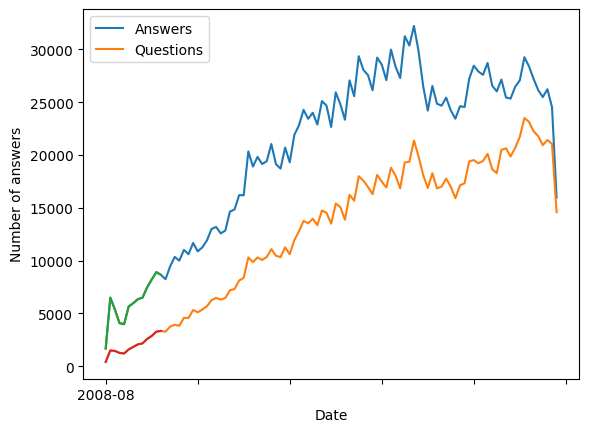

In [4]:
# Make plot reponce and answer by time group by month
answers_month = answers.copy()
answers_month['CreationDate'] = answers_month['CreationDate'].str[:7]
plot = answers_month['CreationDate'].value_counts().sort_index().plot()
plot.set_xlabel('Date')
plot.set_ylabel('Number of answers')

# Make plot reponce and answer by time group by month
questions_month = questions.copy()
questions_month['CreationDate'] = questions_month['CreationDate'].str[:7]
plot = questions_month['CreationDate'].value_counts().sort_index().plot()

# Zoom in 2008-08-01T13:57:07Z at 2009-08-12T04:25:38Z
answers_month = answers_month[(answers_month['CreationDate'] >= '2008-08') & (answers_month['CreationDate'] <= '2009-08')]
plot = answers_month['CreationDate'].value_counts().sort_index().plot()

questions_month = questions_month[(questions_month['CreationDate'] >= '2008-08') & (questions_month['CreationDate'] <= '2009-08')]
plot = questions_month['CreationDate'].value_counts().sort_index().plot()

plt.legend(['Answers', 'Questions'])

plt.savefig('all.png')





               Id  OwnerUserId CreationDate  ParentId  Score  \
1029093  19105819    2751573.0   2013-10-01  19067570      0   
1029094  19105833    1519058.0   2013-10-01  19105770      1   
1029095  19105837    1642266.0   2013-10-01  19088480      0   
1029096  19105841    2526212.0   2013-10-01  19105620      4   
1029097  19105901      10474.0   2013-10-01    897630     -1   

                                                      Body  
1029093  <p>Cognos ships with Tomcat. If you follow the...  
1029094  <p>you must use a delimiter in your function.....  
1029095  <p>Alright, problem solved. After trying out v...  
1029096  <p>This is what I came up with:</p>\n\n<h3>UPD...  
1029097  <p>I'm going to share my own simple option par...  


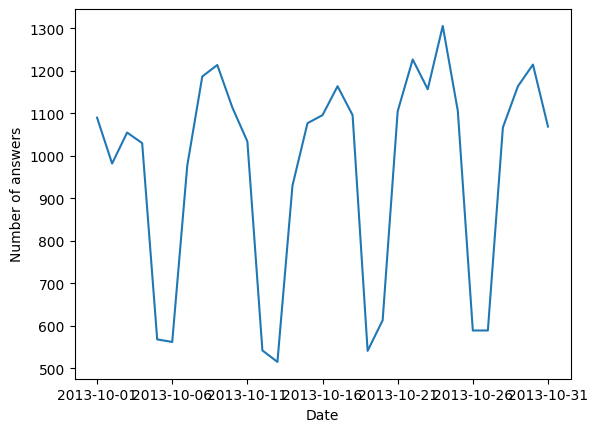

In [11]:
answers_2013_08 = answers.copy()
# Keep only creation date contain 2013-10
answers_2013_08 = answers_2013_08[answers_2013_08['CreationDate'].str.contains('2013-10')]
answers_2013_08['CreationDate'] = answers_2013_08['CreationDate'].str[:10]
print(answers_2013_08.head())
plot = answers_2013_08['CreationDate'].value_counts().sort_index().plot()
plot.set_xlabel('Date')
plot.set_ylabel('Number of answers')
plt.show()


Text(0, 0.5, 'Number of answers')

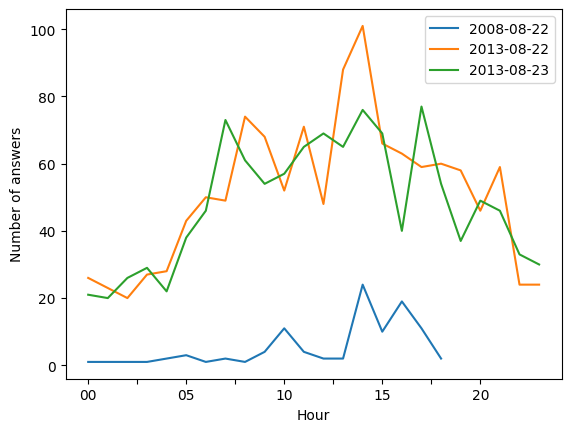

In [12]:
answers_2013_08_22 = answers.copy()
answers_2013_08_22 = answers_2013_08_22[answers_2013_08_22['CreationDate'].str.contains('2013-10-22')]
answers_2013_08_22['CreationDate'] = answers_2013_08_22['CreationDate'].str[11:13]

answers_2013_08_23 = answers.copy()
answers_2013_08_23 = answers_2013_08_23[answers_2013_08_23['CreationDate'].str.contains('2013-10-23')]
answers_2013_08_23['CreationDate'] = answers_2013_08_23['CreationDate'].str[11:13]

answers_2008_08_22 = answers.copy()
answers_2008_08_22 = answers_2008_08_22[answers_2008_08_22['CreationDate'].str.contains('2008-08-22')]
answers_2008_08_22['CreationDate'] = answers_2008_08_22['CreationDate'].str[11:13]

ax = answers_2008_08_22['CreationDate'].value_counts().sort_index().plot()
ax = answers_2013_08_22['CreationDate'].value_counts().sort_index().plot()
ax = answers_2013_08_23['CreationDate'].value_counts().sort_index().plot()
ax.legend(['2008-08-22', '2013-08-22', '2013-08-23'])
ax.set_xlabel('Hour')
ax.set_ylabel('Number of answers')


Text(0, 0.5, 'Number of answers')

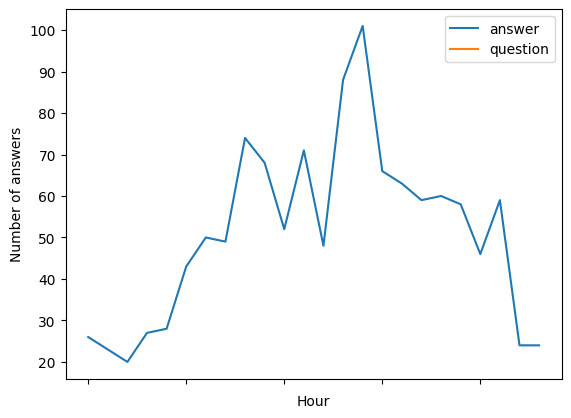

In [13]:
questions_2013_08_22 = questions.copy()
questions_2013_08_22 = questions_2013_08_22[questions_2013_08_22['CreationDate'].str.contains('2013-10-22')]
questions_2013_08_22['CreationDate'] = questions_2013_08_22['CreationDate'].str[11:13]


ax = answers_2013_08_22['CreationDate'].value_counts().sort_index().plot()
ax = questions_2013_08_22['CreationDate'].value_counts().sort_index().plot()
ax.legend(['answer', 'question'])
ax.set_xlabel('Hour')
ax.set_ylabel('Number of answers')

In [14]:
# question_moy_by_day = questions.copy()
# answers_moy_by_day = answers.copy()
# question_moy_by_day['CreationDate'] = question_moy_by_day['CreationDate'].str[:10]
# answers_moy_by_day['CreationDate'] = answers_moy_by_day['CreationDate'].str[:10]
# # Find day (Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, SunDay) with date
# # question_moy_by_day['CreationDate'] = question_moy_by_day['CreationDate'].apply(lambda x: x.split('-'))
# # question_moy_by_day['CreationDate'] = question_moy_norm_by_day['CreationDate'].apply(lambda x: x[0] + '-' + x[1] + '-' + x[2])
# question_moy_norm_by_day['CreationDate'] = question_moy_norm_by_day['CreationDate'].apply(lambda x: pd.Timestamp(x).dayofweek)
# answers_moy_norm_by_day['CreationDate'] = answers_moy_norm_by_day['CreationDate'].apply(lambda x: pd.Timestamp(x).dayofweek)
# question_moy_norm_by_day_for_plot = question_moy_norm_by_day['CreationDate'].value_counts().sort_index()
# answers_moy_norm_by_day_for_plot = answers_moy_norm_by_day['CreationDate'].value_counts().sort_index()
# question_moy_norm_by_day_for_plot = question_moy_norm_by_day_for_plot / question_moy_norm_by_day_for_plot.sum()
# answers_moy_norm_by_day_for_plot = answers_moy_norm_by_day_for_plot / answers_moy_norm_by_day_for_plot.sum()
# ax = answers_moy_norm_by_day_for_plot.plot()
# ax = question_moy_norm_by_day_for_plot.plot()
# ax.set_xlabel('Day of the week')
# ax.set_ylabel('Number of questions')



# Trend seasonality and residuals

In [1]:
question_moy_by_day = questions.copy()
answers_moy_by_day = answers.copy()
question_moy_by_day['CreationDate'] = question_moy_by_day['CreationDate'].str[:10]
answers_moy_by_day['CreationDate'] = answers_moy_by_day['CreationDate'].str[:10]
# Keep only creation date before 2010
answers_moy_by_day = answers_moy_by_day[answers_moy_by_day['CreationDate'] < '2009-09-15']
question_moy_by_day = question_moy_by_day[question_moy_by_day['CreationDate'] < '2009-09-15']

# Keep only creation date after 2008-09
answers_moy_by_day = answers_moy_by_day[answers_moy_by_day['CreationDate'] > '2008-09-15']
question_moy_by_day = question_moy_by_day[question_moy_by_day['CreationDate'] > '2008-09-15']

question_moy_by_day_for_plot = question_moy_by_day['CreationDate'].value_counts().sort_index()
answers_moy_by_day_for_plot = answers_moy_by_day['CreationDate'].value_counts().sort_index()

print(type(answers_moy_by_day_for_plot))


ax = answers_moy_by_day_for_plot.plot()
ax = question_moy_by_day_for_plot.plot()
# shape plot bigger on x axis
# plt.xlim(0, 100)
ax.legend(['answer', 'question'])
ax.set_xlabel('Day of the week')
ax.set_ylabel('Number of questions')

# save plot
plt.savefig('plot.png')

plot_acf(answers_moy_by_day_for_plot)
plt.savefig('acf/plot_acf_answer.png')
plot_acf(question_moy_by_day_for_plot)
plt.savefig('acf/plot_acf_questions.png')

# Time warping
s1 = answers_moy_by_day_for_plot
s2 = question_moy_by_day_for_plot
# Centred and normalized
s1 = (s1 - s1.mean()) / s1.std()
s2 = (s2 - s2.mean()) / s2.std()

d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path)
plt.savefig('timewarp/plot_dtw_question_answer.png')

NameError: name 'questions' is not defined

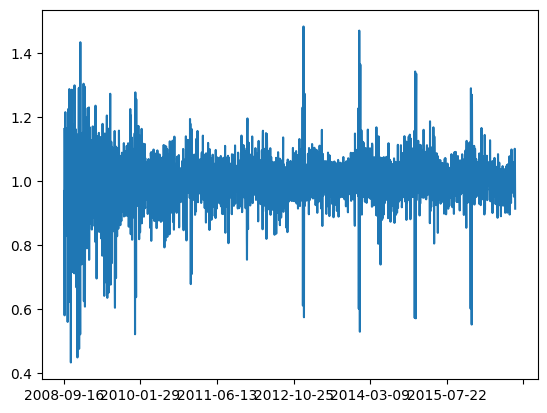

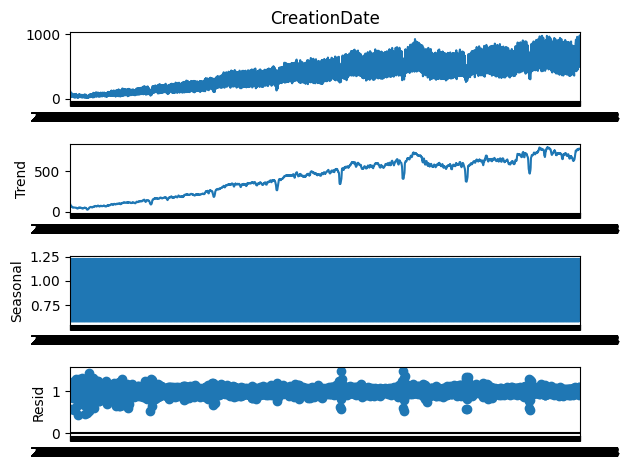

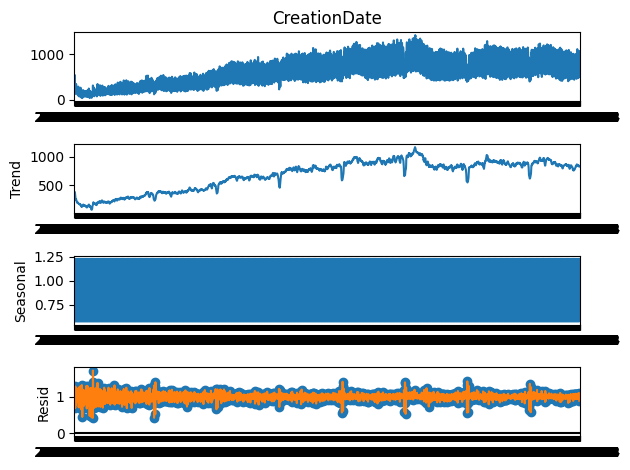

In [6]:
if question_moy_by_day_for_plot is None:
    print('question_moy_by_day_for_plot is None')
    raise SystemExit(0)
decompose_result_mult = seasonal_decompose(question_moy_by_day_for_plot, model='multiplicative', period=7)

question_trend = decompose_result_mult.trend
question_seasonal = decompose_result_mult.seasonal
question_residual = decompose_result_mult.resid
ax = question_residual.plot()

decompose_result_mult.plot()
plt.savefig('decompose_question_result_mult.png')


if answers_moy_by_day_for_plot is None:
    print('answers_moy_by_day_for_plot is None')
    raise SystemExit(0)
decompose_result_mult = seasonal_decompose(answers_moy_by_day_for_plot, model='multiplicative', period=7)

answers_trend = decompose_result_mult.trend
answers_seasonal = decompose_result_mult.seasonal
answers_residual = decompose_result_mult.resid
decompose_result_mult.plot()
# Plot residual
ax = answers_residual.plot()
# ax.set_xlabel('Day of the week')
# ax.set_ylabel('Number of questions')
# plt.savefig('decompose_answer.png')


2008-09-16         NaN
2008-09-17         NaN
2008-09-18         NaN
2008-09-19    1.246687
2008-09-20    1.011265
                ...   
2009-08-10    1.044234
2009-08-11    0.959850
2009-08-12         NaN
2009-08-13         NaN
2009-08-14         NaN
Name: resid, Length: 333, dtype: float64
2008-09-16    NaN
2008-09-17    NaN
2008-09-18    NaN
2008-09-19    1.2
2008-09-20    1.1
             ... 
2009-08-10    1.1
2009-08-11    1.0
2009-08-12    1.0
2009-08-13    1.0
2009-08-14    1.0
Name: resid, Length: 333, dtype: float64
2008-12-25     42
2008-12-27     61
2009-01-01     77
2009-01-02    314
Name: CreationDate, dtype: int64
DatetimeIndex(['2008-12-25', '2008-12-27', '2009-01-01', '2009-01-02'], dtype='datetime64[ns]', freq=None)


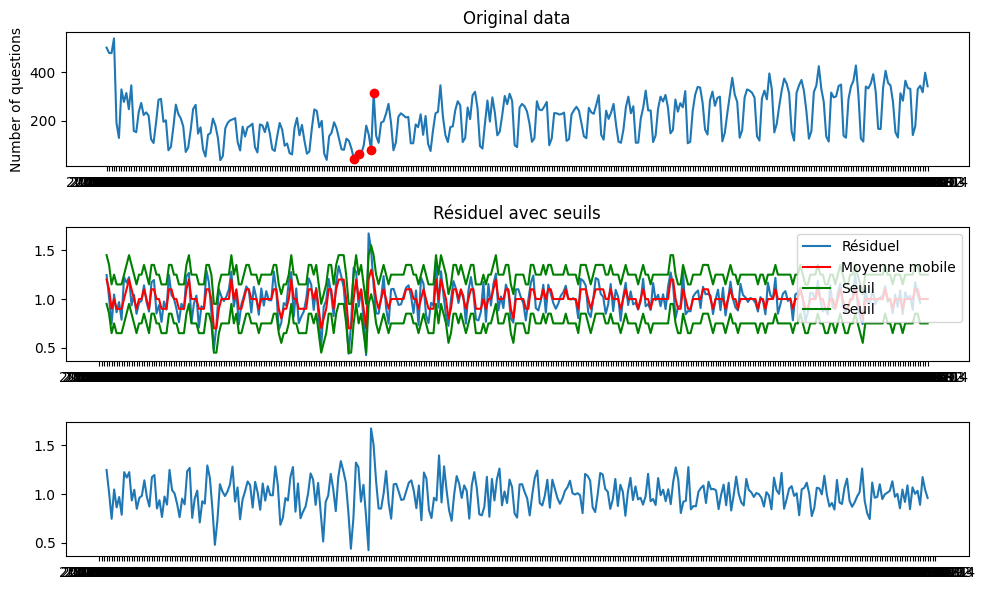

In [ ]:
# Moving average

window_size = 1
# moving_average = np.convolve(residual, np.ones(window_size)/window_size, mode='full')

print(answers_residual)

numbers_series = pd.Series(answers_residual)
 
# Get the moving averages of series
# of observations till the current time
moving_averages = round(numbers_series.ewm(
  alpha=0.5, adjust=False).mean(), window_size)
 
# Convert pandas series back to list
moving_averages_list = moving_averages.tolist()

print(moving_averages)

# Define threshold for anomaly detection

threshold = 0.25

# Detect anomalies

anomalies = answers_moy_by_day_for_plot[np.abs(answers_residual - moving_averages) > threshold]
print(anomalies)
# Add index to the anomalies to get the date
anomalies_index = anomalies.index
anomalies_index = pd.to_datetime(anomalies_index)

print (anomalies_index)
# Rename Index to Date

distance = np.abs(answers_residual - moving_averages)
# For each anomalies print value and means of the residual coresponding
# for i, date in enumerate(anomalies_index):
#     print(i)
#     print(f'Anomalie détectée le {date} avec une valeur de {anomalies[i]} et une moyenne de {moving_averages[date]}')

# Plot original data and in 2nd plot the residual and moving average and threshold
fig, ax = plt.subplots(3, 1, figsize=(10, 6))
ax[0].plot(answers_moy_by_day_for_plot)
ax[0].plot(anomalies, 'ro')
ax[0].set_ylabel('Number of questions')
ax[0].set_title('Original data')
ax[1].plot(answers_residual, label='Résiduel')
ax[1].plot(moving_averages, 'r', label='Moyenne mobile')
ax[1].plot(moving_averages + threshold, 'g', label='Seuil')
ax[1].plot(moving_averages - threshold, 'g', label='Seuil')
ax[1].set_title('Résiduel avec seuils')
ax[1].set_ylabel('')
ax[1].legend()
ax[2].plot(answers_residual)

plt.tight_layout()

plt.savefig('anomalies.png')



In [ ]:
# Seuil pour la détection d'anomalies
threshold = 0.4
threshold_question = 0.4
anomalies = np.where(answers_residual > 1 + threshold)[0]
anomalies = np.concatenate((anomalies, np.where(answers_residual < 1 - threshold)[0]))

# Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Tracé des données originales avec les anomalies
ax[0].plot(answers_moy_by_day_for_plot, label='nombre de réponses')
# Tendance + saisonnalité
ax[0].plot(answers_trend * answers_seasonal, label='Tendance + saisonnalité')

ax[0].plot(anomalies, answers_moy_by_day_for_plot[anomalies], 'ro', label='Anomalies')  # Points rouges aux indices des anomalies
ax[0].set_ylabel('Nombre de questions')
ax[0].set_title('Données originales')
ax[0].legend()

# Tracé du résiduel avec les lignes de seuil
ax[1].plot(answers_residual, label='Résiduel')
ax[1].axhline(1 + threshold, color='r', linestyle='--', label=f'Seuil +{threshold}')
ax[1].axhline(1 - threshold, color='r', linestyle='--', label=f'Seuil -{threshold}')
ax[1].plot(anomalies, answers_residual[anomalies], 'ro', label='Anomalies') 
ax[1].set_title('Résiduel avec seuils')
ax[1].legend()

plt.tight_layout()
plt.savefig('graphs/Questions_anomalies.png')
plt.show()

question_anomalies = np.where(question_residual > 1 + threshold_question)[0]
question_anomalies = np.concatenate((question_anomalies, np.where(question_residual < 1 - threshold_question)[0]))

# Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Tracé des données originales avec les anomalies
ax[0].plot(question_moy_by_day_for_plot, label='nombre de questions')
# Tendance + saisonnalité
ax[0].plot(question_trend * question_seasonal, label='Tendance * saisonnalité')

ax[0].plot(question_anomalies, question_moy_by_day_for_plot[question_anomalies], 'ro', label='Anomalies')  # Points rouges aux indices des anomalies
ax[0].set_ylabel('Nombre de questions')
ax[0].set_title('Données originales')
ax[0].legend()

# Tracé du résiduel avec les lignes de seuil
ax[1].plot(question_residual, label='Résiduel')
ax[1].axhline(1 + threshold_question, color='r', linestyle='--', label=f'Seuil +{threshold_question}')
ax[1].axhline(1 - threshold_question, color='r', linestyle='--', label=f'Seuil -{threshold_question}')
ax[1].plot(question_anomalies, question_residual[question_anomalies], 'ro', label='Anomalies') 
ax[1].set_title('Résiduel avec seuils')
ax[1].legend()

plt.tight_layout()
plt.savefig('graphs/Aswers_anomalies.png')
plt.show()


# Print days answer anomalies
for i, index in enumerate(anomalies):
    print(f'ANSWER : Anomalie détectée le {answers_moy_by_day_for_plot.index[index]} avec une valeur de {answers_moy_by_day_for_plot[index]}')

# Print days question anomalies
for i, index in enumerate(question_anomalies):
    print(f'QUESTION : Anomalie détectée le {question_moy_by_day_for_plot.index[index]} avec une valeur de {question_moy_by_day_for_plot[index]} ')



In [ ]:
# # Group by tags
# print(len(questions))
# print(len(questions_top))

# top_tags_number_day_years = questions_top[['CreationDate','Tag']]
# # top_tags_number_day_years['CreationDate'] = questions_top['CreationDate'].str[:10]
# top_tags_number_day_years = top_tags_number_day_years[top_tags_number_day_years['CreationDate'] < pd.to_datetime('2009-09-15')]
# top_tags_number_day_years = top_tags_number_day_years[top_tags_number_day_years['CreationDate'] > pd.to_datetime('2008-08-15')]
# top_tags_number_day_years = top_tags_number_day_years.sort_values(by='CreationDate').explode('Tag').reset_index()

# # Keep number week on years
# top_tags_number_day_years['CreationDate'] = top_tags_number_day_years['CreationDate'].dt.week



# # Create dico wirh keys each tag in top tag and value Df coresponding group by date
# dico = {
#     tag: top_tags_number_day_years[top_tags_number_day_years['Tag'] == tag]
#                 .groupby('CreationDate').count()
#                                     # .sort_values(by='CreationDate').reset_index(drop=True)
#     for tag in top_tags
# }

# print(dico)

# plt.figure(figsize=(10, 6))
# for tag in top_tags:
#     plt.plot(dico[tag], label=tag)
# plt.xlabel('Date')
# plt.ylabel('Number of questions')
# plt.title('Number of questions per tag over time')
# plt.legend()
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()



# L'idée était de voir si les heures d'activité par utilisateur pouvait être un bon indicateur. Mais il n'y pas assez d'acctivité pour faire une analyse pertinente.

# Voir la popularité des tags

/tmp/ipykernel_5771/1804595727.py:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  by_tag = by_tag[(by_tag['CreationDate'] <= pd.to_datetime('2009-08-08')) & (by_tag['CreationDate'] >= pd.to_datetime('2008-09-15'))]
/tmp/ipykernel_5771/1804595727.py:16: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  total_date = total_date[(total_date['CreationDate'] <= pd.to_datetime('2009-08-08')) & (total_date['CreationDate'] >= pd.to_datetime('2008-09-15'))]


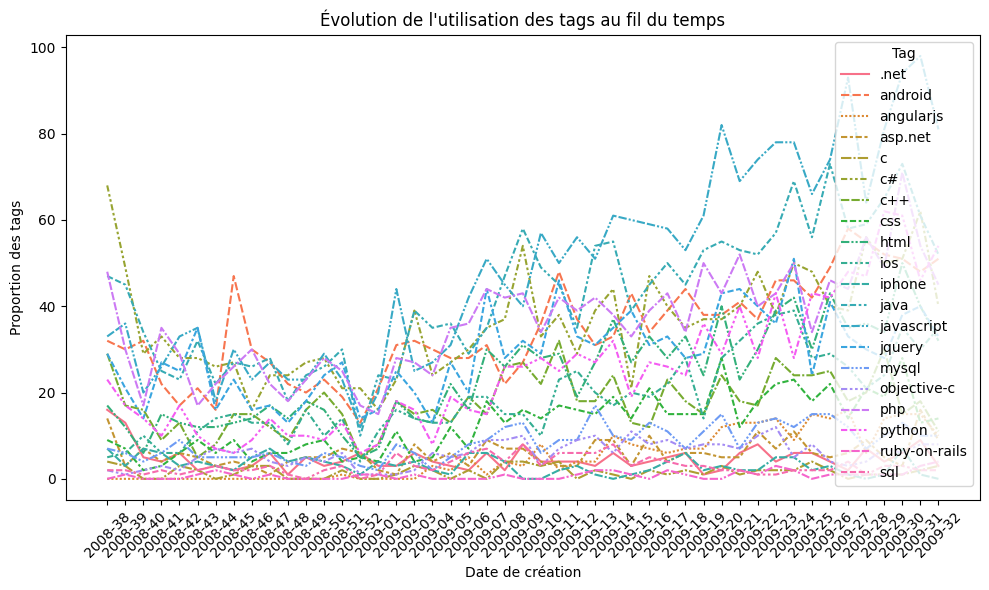

In [ ]:
by_tag = questions_top[['CreationDate', 'Tag']].copy()
total_date = questions[['CreationDate', 'Tag']].copy()
by_tag['CreationDate'] = pd.to_datetime(by_tag['CreationDate'])
by_tag['CreationDate'] = by_tag['CreationDate'].dt.date
total_date['CreationDate'] = pd.to_datetime(total_date['CreationDate'])
total_date['CreationDate'] = total_date['CreationDate'].dt.date

# year and month and week
by_tag = by_tag[(by_tag['CreationDate'] <= pd.to_datetime('2009-08-08')) & (by_tag['CreationDate'] >= pd.to_datetime('2008-09-15'))]
remove_me1 = by_tag.copy()
by_tag['CreationDate'] = by_tag['CreationDate'].apply(lambda x: f"{pd.Timestamp(x).year}-{pd.Timestamp(x).isocalendar().week:02d}")
# Change only 2008-01 to 2009-01, because the last part week of 2008 is not complete and it's the first week of 2009
by_tag['CreationDate'] = by_tag['CreationDate'].apply(lambda x: '2009-01' if x == '2008-01' else x)

remove_me2 = by_tag.copy()
total_date = total_date[(total_date['CreationDate'] <= pd.to_datetime('2009-08-08')) & (total_date['CreationDate'] >= pd.to_datetime('2008-09-15'))]
total_date['CreationDate'] = total_date['CreationDate'].apply(lambda x: f"{pd.Timestamp(x).year}-{pd.Timestamp(x).isocalendar().week:02d}")
total_date['CreationDate'] = total_date['CreationDate'].apply(lambda x: '2009-01' if x == '2008-01' else x)



by_tag = by_tag.explode('Tag').reset_index()
# unique_years = by_tag['CreationDate'].unique()
by_tag = by_tag[by_tag['Tag'].isin(top_tags)]
# unique_years = by_tag['CreationDate'].unique()
by_tag = by_tag.groupby(['Tag', 'CreationDate']).size().reset_index(name='count')


# unique_years = by_tag['CreationDate'].unique()
# display courbe of activity by tag
by_tag_pivot = by_tag.pivot(index='CreationDate', columns='Tag', values='count').fillna(0)
by_tag_popular_beetwen = by_tag_pivot.div(by_tag_pivot.sum(axis=1), axis=0)

total_date = total_date.groupby('CreationDate').size().reset_index(name='count').fillna(0)
by_tag_popular_total = by_tag_pivot.div(total_date.set_index('CreationDate')['count'], axis=0).fillna(0)



plt.figure(figsize=(10, 6))
sns.lineplot(data=by_tag_pivot)
plt.title('Évolution de l\'utilisation des tags au fil du temps')
plt.xlabel('Date de création')
plt.ylabel('Proportion des tags')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

for tag in top_tags :
    # Get data for tag
    data = by_tag_pivot[tag]
    plot_acf(data)
    plt.title(f'Autocorrelation for tag {tag}')
    plt.savefig(f'acf/acf_{tag}.png')
    plt.close()


In [ ]:
# Convert the DataFrame to a NumPy array
timeseries = np.array(by_tag_pivot.values, dtype=np.double)

# Compute the distance matrix using dtw.distance_matrix_fast()
ds = dtw.distance_matrix_fast(timeseries)

for tag1 in top_tags:
    for tag2 in top_tags:
        if tag1 != tag2:
            s1 = by_tag_pivot[tag1]
            s2 = by_tag_pivot[tag2]
            # Centred and normalized
            s1 = (s1 - s1.mean()) / s1.std()
            s2 = (s2 - s2.mean()) / s2.std()

            d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
            best_path = dtw.best_path(paths)
            dtwvis.plot_warpingpaths(s1, s2, paths, best_path)
            plt.title(f'DTW distance between {tag1} and {tag2} : {d}')
            plt.savefig(f'timewarp/dtw_{tag1}_{tag2}.png')
            plt.close()

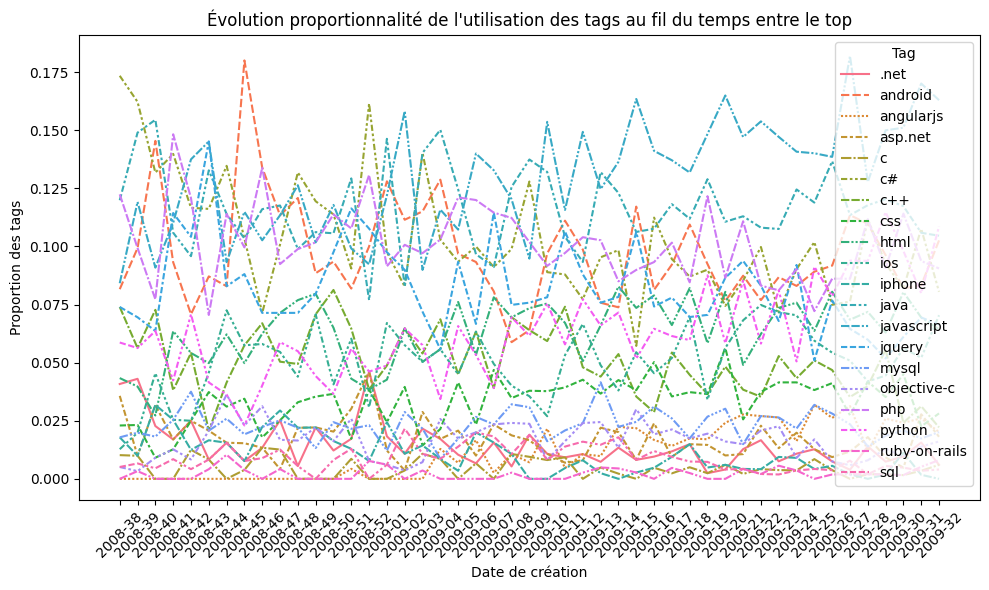

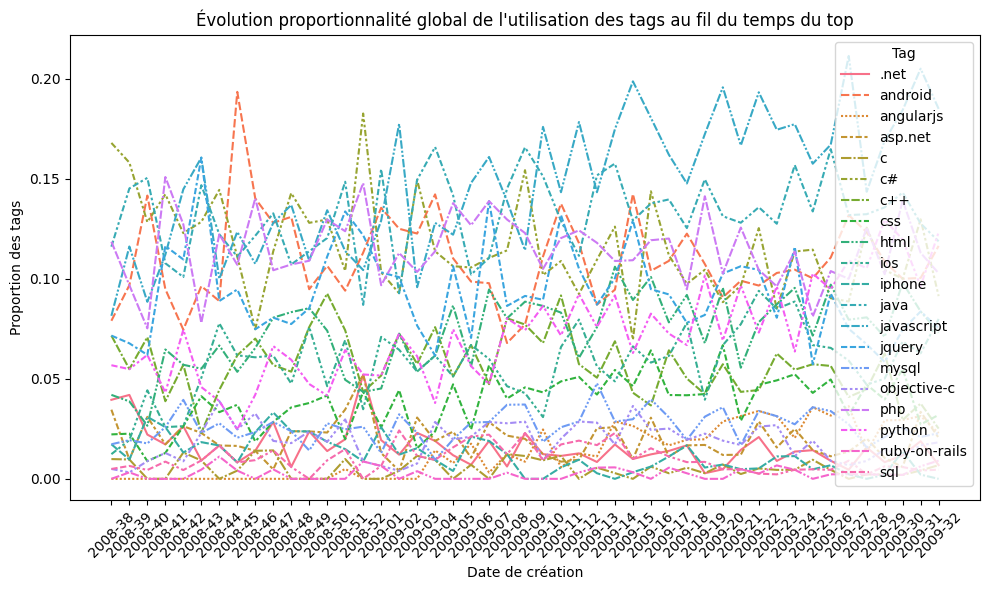

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=by_tag_popular_beetwen)
plt.title('Évolution proportionnalité de l\'utilisation des tags au fil du temps entre le top')
plt.xlabel('Date de création')
plt.ylabel('Proportion des tags')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=by_tag_popular_total)
plt.title('Évolution proportionnalité global de l\'utilisation des tags au fil du temps du top')
plt.xlabel('Date de création')
plt.ylabel('Proportion des tags')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

for tag in top_tags :
    # Get data for tag
    data = by_tag_popular_total[tag]
    plot_acf(data)
    plt.title(f'Autocorrelation proportional for tag {tag}')
    plt.savefig(f'acf/acf_{tag}.png')
    plt.close()

/home/pe/Documents/M2/Data/tp/.venv/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


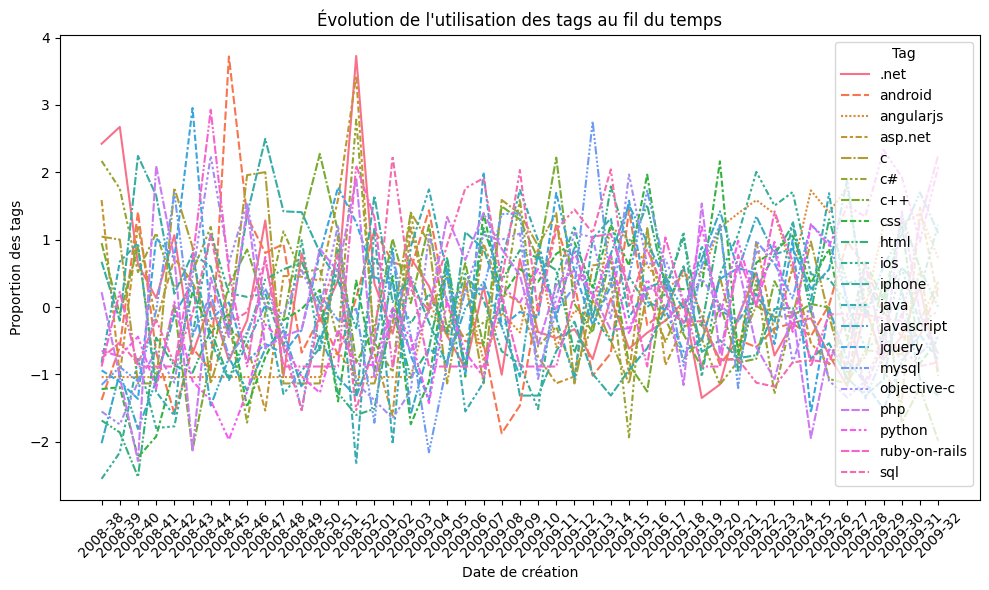

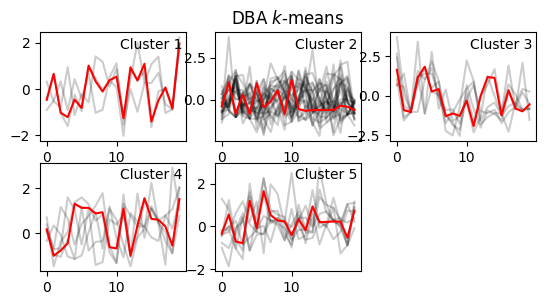

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import KernelKMeans

# Centred and normalized
tag_cluster = by_tag_popular_total.copy()
tag_cluster = (tag_cluster - tag_cluster.mean()) / tag_cluster.std()

# plot tag cluster
plt.figure(figsize=(10, 6))
sns.lineplot(data=tag_cluster)
plt.title('Évolution de l\'utilisation des tags au fil du temps')
plt.xlabel('Date de création')
plt.ylabel('Proportion des tags')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


model = TimeSeriesKMeans(n_clusters=5, metric="dtw",
                         max_iter=10)

# model = KernelKMeans(n_clusters=5,
#                       kernel="gak",
#                       kernel_params={"sigma": "auto"},
#                       n_init=20)
y_pred = model.fit_predict(tag_cluster)

sz = by_tag_pivot.shape[1]

for yi in range(5):
    plt.subplot(3, 3, 4 + yi)
    for xx in tag_cluster.values[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=0.2)
        
    plt.plot(model.cluster_centers_[yi].ravel(), "r-")
    # plt.xlim(0, sz)
    # plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

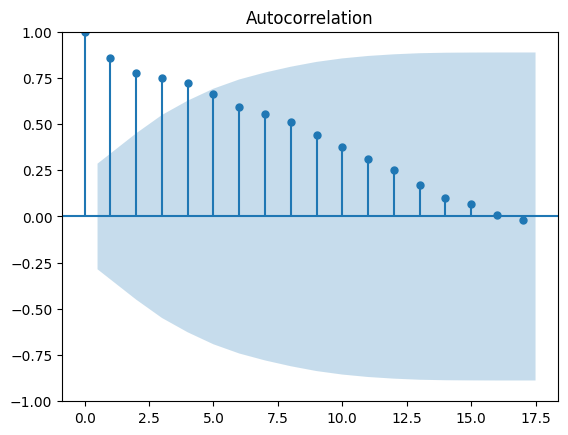

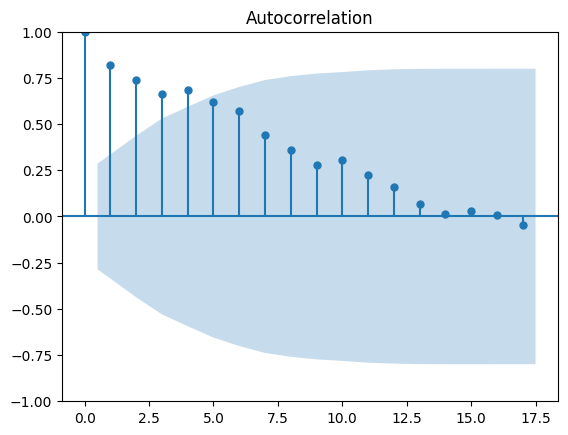

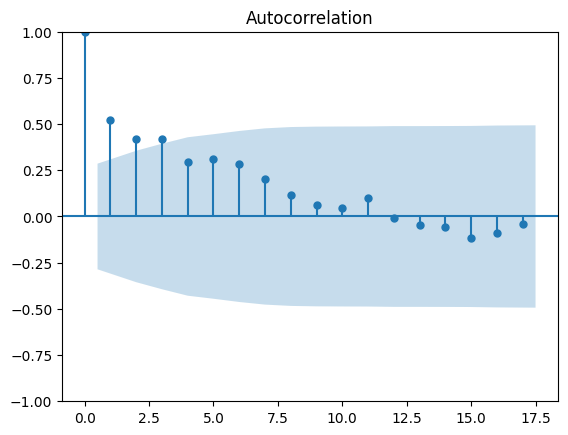

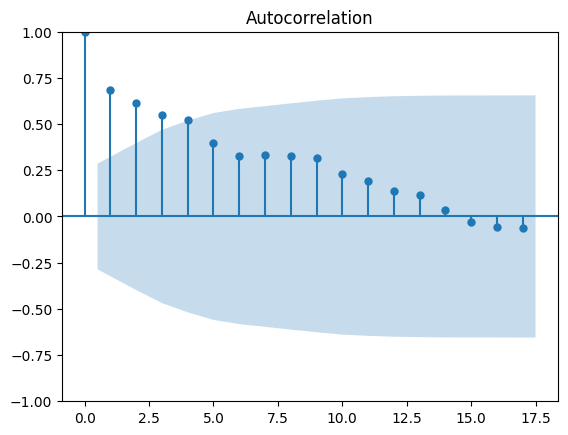

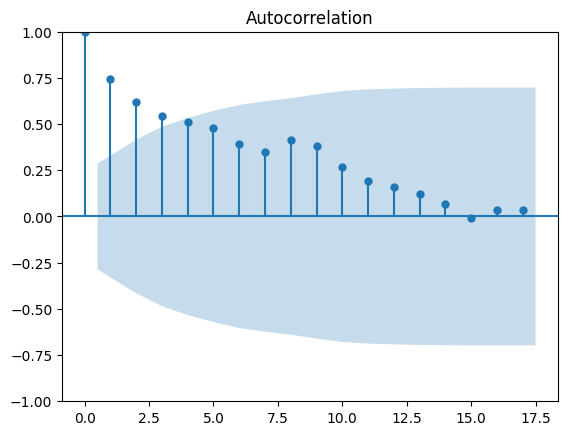

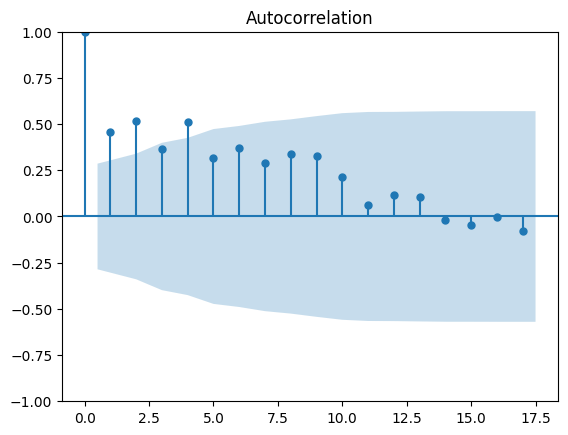

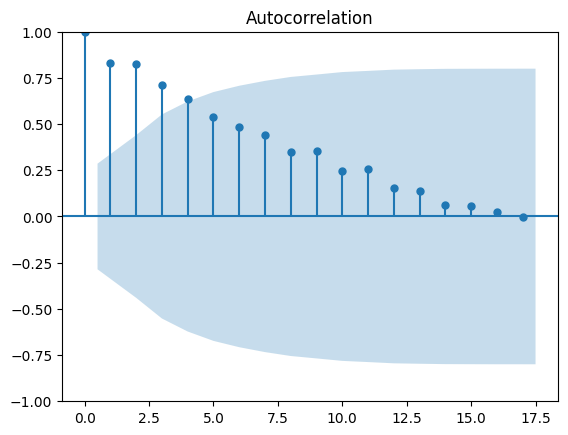

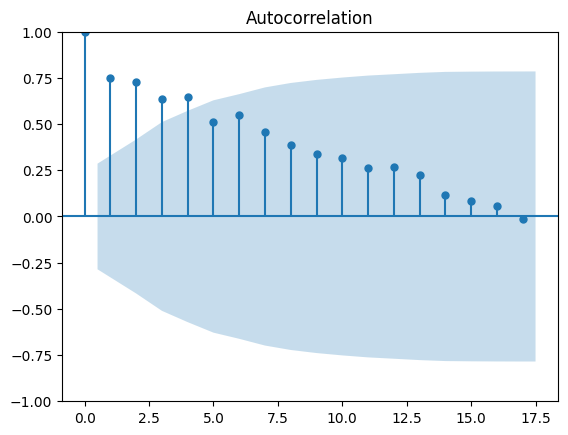

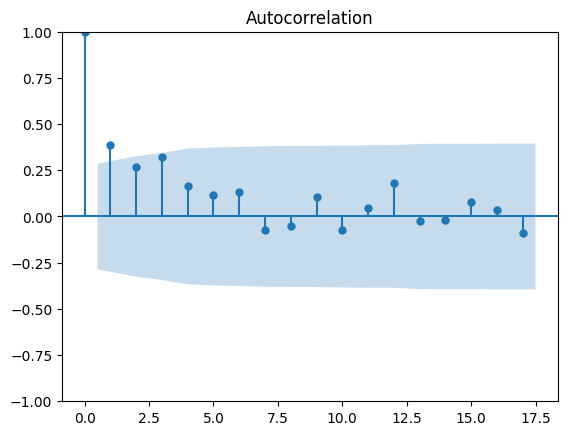

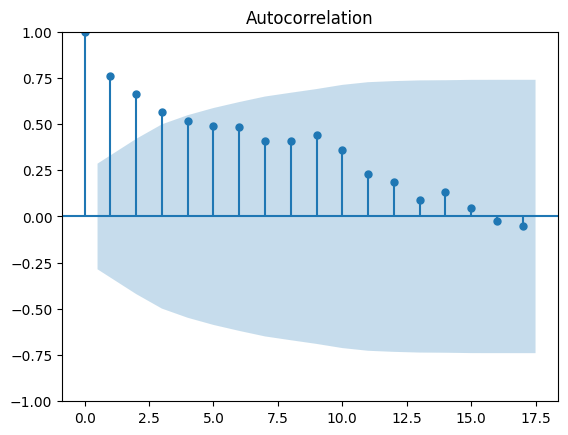

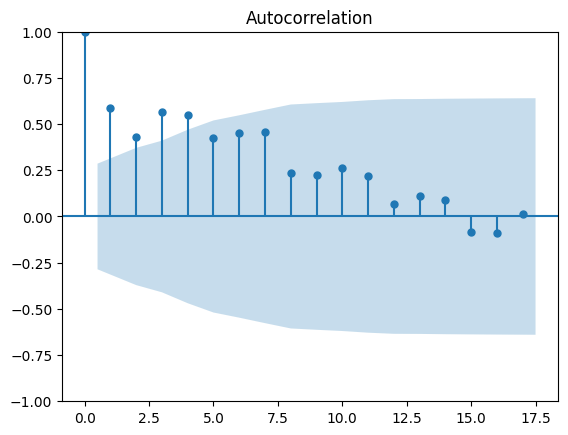

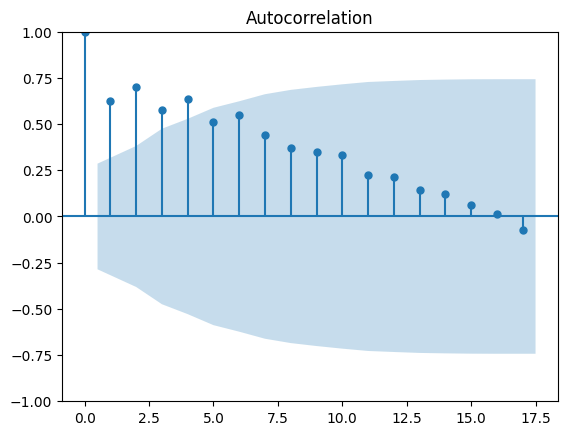

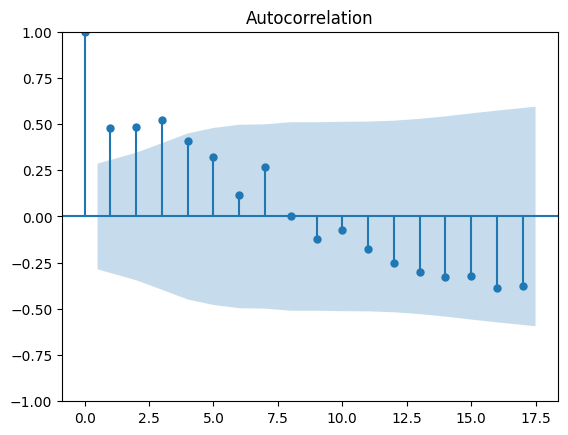

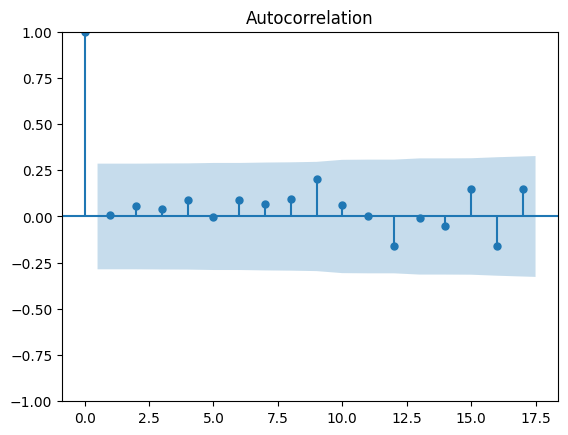

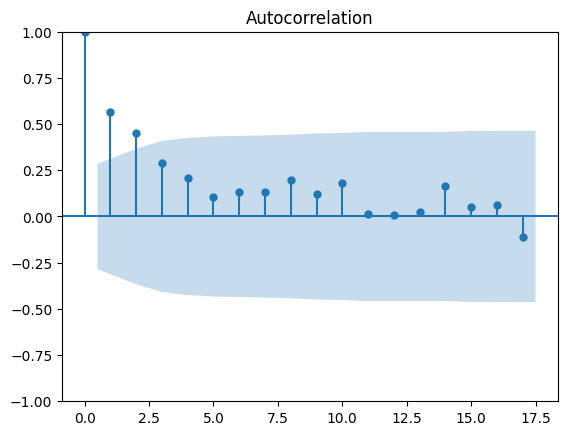

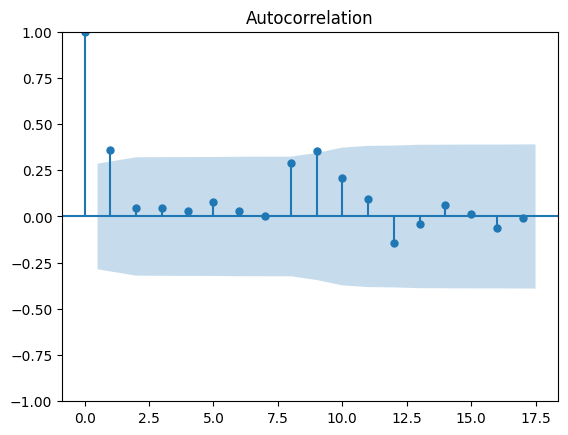

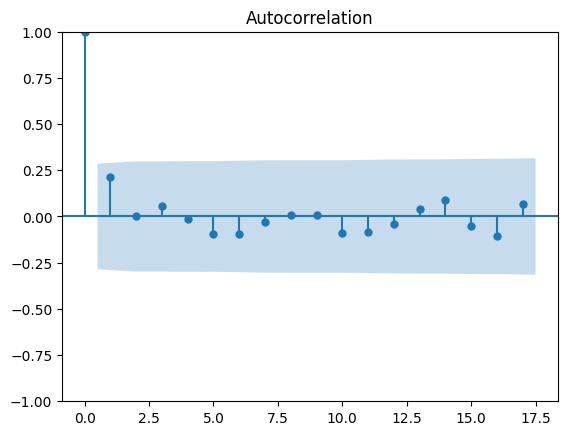

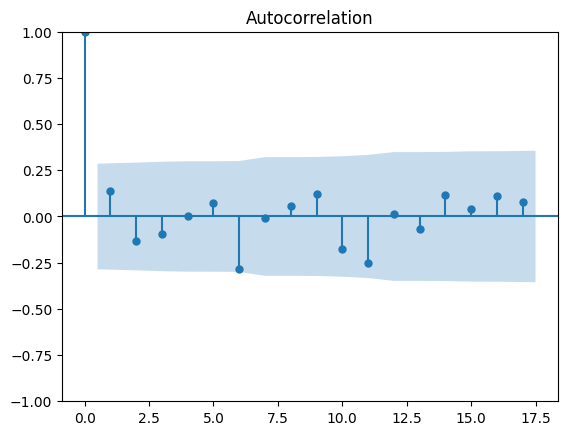

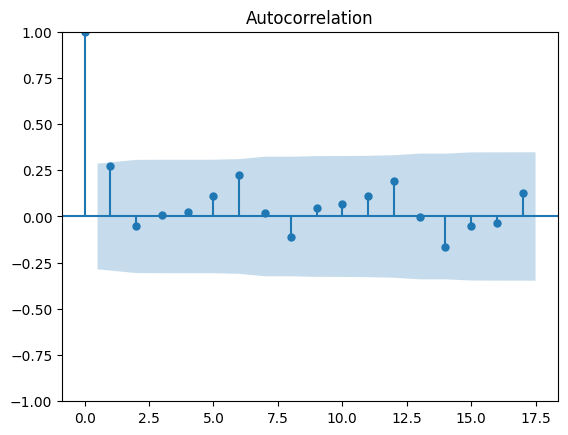

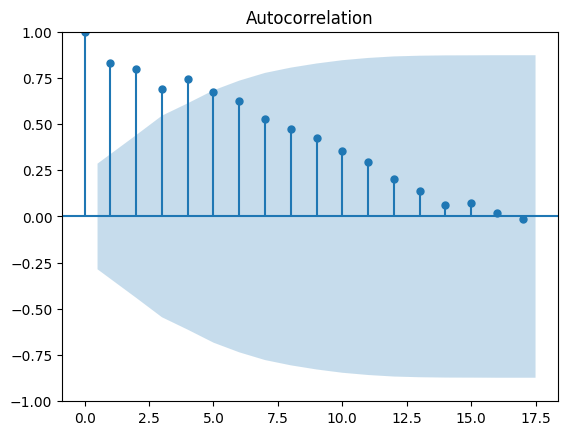

In [ ]:
# For each tag calculate trend and seasonality, and residual
for tag in top_tags :
    # Get data for tag
    data = by_tag_pivot[tag]
    plot_acf(data)

    # Decompose data
    # decompose_result_mult = seasonal_decompose(data, model='multiplicative', period=7)
    # # Get trend, seasonal and residual
    # trend = decompose_result_mult.trend
    # seasonal = decompose_result_mult.seasonal
    # residual = decompose_result_mult.resid
    # # Plot
    # decompose_result_mult.plot()
    # plt.title(tag)
    # plt.tight_layout()
    # plt.show()


In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Create a list of lists of tags for each question
# trans questions['Tag'] to list of string
freq_pat = questions_top['Tag'].dropna().tolist()
# print(freq_pat)
# freq_pat = [(str(element) for element in list_) for list_ in freq_pat]


# Step 1: Convert the dataset into a one-hot encoded DataFrame
te = TransactionEncoder()
te_data = te.fit(freq_pat).transform(freq_pat)
df = pd.DataFrame(te_data, columns=te.columns_)

# Step 2: Apply the Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(df, min_support=0.002, use_colnames=True)

frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
print(frequent_itemsets)


rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.2)

rules


      support                  itemsets
78   0.183280              (javascript)
77   0.158705                    (java)
24   0.138646                      (c#)
115  0.136273                     (php)
4    0.126014                 (android)
..        ...                       ...
306  0.002067        (html5, html, css)
110  0.002067               (parse.com)
97   0.002067  (multidimensional-array)
275  0.002067     (reactjs, javascript)
169  0.002067              (ajax, html)

[318 rows x 2 columns]


antecedents    consequents  antecedent support  consequent support  \
0    (javascript)       (jquery)            0.183280            0.107258   
1        (jquery)   (javascript)            0.107258            0.183280   
2          (html)          (css)            0.089573            0.046700   
3           (css)         (html)            0.046700            0.089573   
4    (javascript)         (html)            0.183280            0.089573   
..            ...            ...                 ...                 ...   
367         (css)  (html5, html)            0.046700            0.003445   
368     (reactjs)   (javascript)            0.002144            0.183280   
369  (javascript)      (reactjs)            0.183280            0.002144   
370        (ajax)         (html)            0.017991            0.089573   
371        (html)         (ajax)            0.089573            0.017991   

      support  confidence       lift  leverage  conviction  zhangs_metric  
0    0.057342    0.312865   2.916952  0.037684    1.299225       0.804653  
1    0.057342    0.534618   2.916952  0.037684    1.754946       0.736132  
2    0.037896    0.423077   9.059395  0.033713    1.652386       0.977143  
3    0.037896    0.811475   9.059395  0.033713    4.829223       0.933198  
4    0.036212    0.197577   2.205773  0.019795    1.134598       0.669316  
..        ...         ...        ...       ...         ...            ...  
367  0.002067    0.044262  12.847869  0.001906    1.042708       0.967341  
368  0.002067    0.964286   5.261278  0.001674   22.868167       0.811672  
369  0.002067    0.011278   5.261278  0.001674    1.009239       0.991689  
370  0.002067    0.114894   1.282684  0.000456    1.028608       0.224422  
371  0.002067    0.023077   1.282684  0.000456    1.005206       0.242067  

[372 rows x 10 columns]

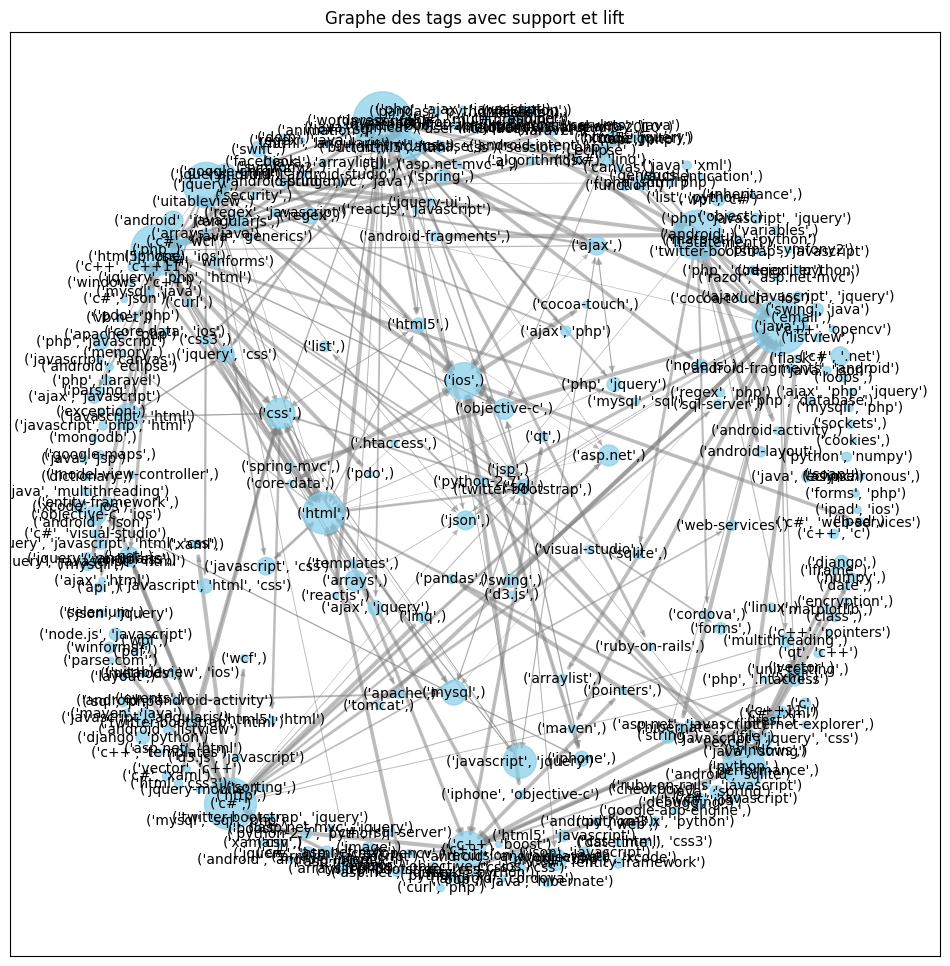

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.clear()
threshold_support = frequent_itemsets['support'].quantile(0)
for index, row in frequent_itemsets.iterrows():
    if row['support'] >= threshold_support:
        itemset = tuple(row['itemsets'])
        G.add_node(itemset, support=row['support'])

for index, row in rules.iterrows():
    antecedent = tuple(row['antecedents'])
    consequent = tuple(row['consequents'])
    if G.has_node(antecedent) and G.has_node(consequent):
        G.add_edge(antecedent, consequent, weight=row['confidence'], confidence=row['confidence'], lift=row['lift'], leverage=row['leverage'], conviction=row['conviction'], zhang=row['zhangs_metric'])
        # G.add_edge(antecedent, consequent, weight=row['confidence_norm'], confidence=row['confidence'])

node_sizes = [10000 * G.nodes[node]['support'] for node in G.nodes]
edge_weights = [G[u][v]['weight'] * 3 for u, v in G.edges]

plt.close()
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="skyblue", alpha=0.7)
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

plt.title("Graphe des tags avec support et lift")
plt.savefig('Graph_association_rules2.png')

nx.write_gexf(G, 'graph.gexf')


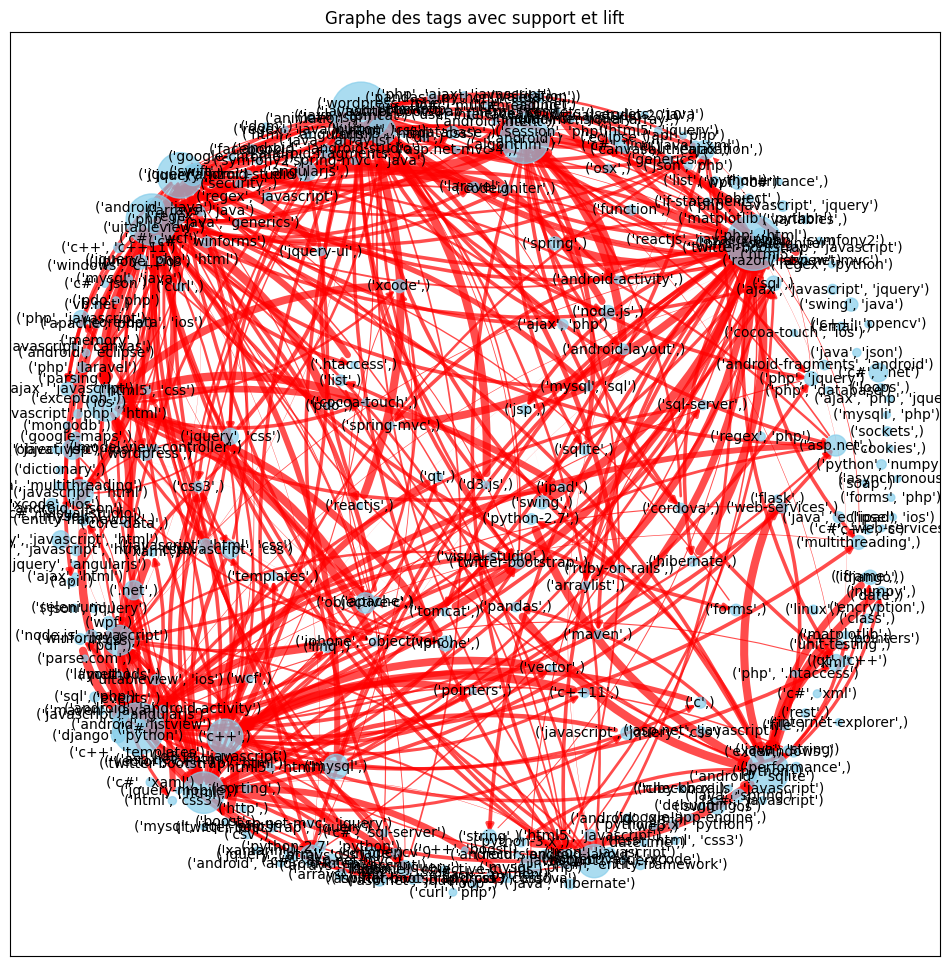

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.clear()

list_confidence = rules['confidence'].tolist()
# centrer et normaliser
list_confidence = (list_confidence - np.mean(list_confidence)) / np.std(list_confidence)
rules['confidence_norm'] = list_confidence

# Seuil pour les nœuds
threshold_support = frequent_itemsets['support'].quantile(0)  # Ajustez selon vos besoins
for index, row in frequent_itemsets.iterrows():
    if row['support'] >= threshold_support:
        itemset = tuple(row['itemsets'])
        G.add_node(itemset, support=row['support'])

# Ajout des arêtes avec vérification de réciprocité
for index, row in rules.iterrows():
    antecedent = tuple(row['antecedents'])
    consequent = tuple(row['consequents'])
    if G.has_node(antecedent) and G.has_node(consequent):
        G.add_edge(antecedent, consequent, weight=row['confidence_norm'], confidence=row['confidence'])

# Calcul des tailles de nœud et des poids d'arêtes
node_sizes = [10000 * G.nodes[node]['support'] for node in G.nodes]

# Tracé des nœuds
plt.close()
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="skyblue", alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

eppaiseur = 3

# Tracé des arêtes avec vérification de réciprocité
for u, v in G.edges():
    if G.has_edge(v, u):  # Si une arête inverse existe
        # Tracer le lien réciproque avec une couleur et courbure différentes
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(u, v)],
            width = eppaiseur * G[u][v]['weight'],  # Ajustement de largeur
            alpha=0.7,
            edge_color="red",  # Couleur différente pour le lien réciproque
            connectionstyle="arc3,rad=0.2"  # Courbure
        )
    else:
        # Tracer les arêtes non réciproques normalement
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(u, v)],
            width= eppaiseur * G[u][v]['weight'],
            alpha=0.5,
            edge_color="gray"
        )

plt.title("Graphe des tags avec support et lift")
plt.savefig('Graph_association_rules2.png')
plt.show()


In [ ]:
# harmonic_centralit

harm = nx.harmonic_centrality(G, distance='confidence')

print(harm)


{('html5', 'javascript'): 0, ('android', 'xml'): 0, ('css', 'html', 'css3'): 0, ('css3',): 232.45899073765165, ('parsing',): 0, ('date',): 0, ('android', 'java'): 0, ('php', 'database'): 0, ('spring',): 178.37636815409192, ('c#', '.net'): 0, ('api',): 269.7293004256822, ('html5', 'html', 'css'): 0, ('excel',): 0, ('.htaccess',): 276.110464192701, ('cordova',): 217.85713581802068, ('.net',): 148.10182557304924, ('flask',): 184.26815610384224, ('c#', 'entity-framework'): 0, ('asp.net-mvc', 'jquery'): 0, ('uitableview',): 22.375749487534243, ('wordpress', 'php'): 0, ('html', 'css'): 203.33771663486775, ('objective-c',): 20.07198974080327, ('entity-framework',): 194.1463436968971, ('cocoa-touch',): 39.72973975864288, ('regex', 'python'): 0, ('reactjs', 'javascript'): 0, ('html5', 'html'): 177.29989070914948, ('c#', 'javascript'): 0, ('jsp',): 222.6958813143643, ('python-2.7',): 150.80052517502702, ('wordpress',): 205.06774685386182, ('android-fragments', 'android'): 0, ('javascript',): 184

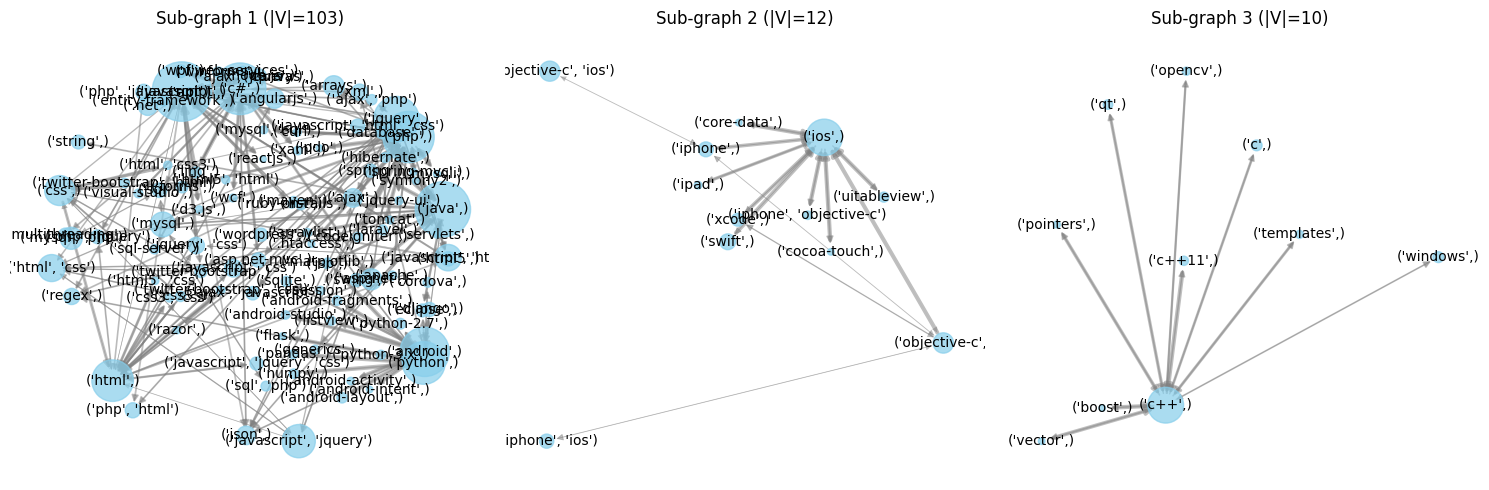

In [ ]:
import math

sub_graph = [sub for sub in nx.strongly_connected_components(G) if len(sub) >= 2]

# Créer une figure avec une grille adaptée
num_subgraphs = len(sub_graph)
cols = 3
rows = math.ceil(num_subgraphs / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

# Dessiner chaque sous-graphe
for i, sub in enumerate(sub_graph):
    G_sub = G.subgraph(sub)

    node_sizes = [10000 * G_sub.nodes[node]['support'] for node in G_sub.nodes]
    edge_weights = [G_sub[u][v]['weight'] * 1.5 for u, v in G_sub.edges]

    pos = nx.spring_layout(G_sub, k=0.5, seed=42)
    ax = axes[i]
    nx.draw_networkx_nodes(G_sub, pos, ax=ax, node_size=node_sizes, node_color="skyblue", alpha=0.7)
    nx.draw_networkx_edges(G_sub, pos, ax=ax, width=edge_weights, alpha=0.5, edge_color="gray")
    nx.draw_networkx_labels(G_sub, pos, ax=ax, font_size=10, font_family="sans-serif")

    ax.set_title(f"Sub-graph {i + 1} (|V|={len(G_sub.nodes)})")
    ax.axis('off')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
# cluster in sub graph with DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Créer un DataFrame avec les scores PageRank
pr_df = pd.DataFrame(pr.items(), columns=['tag', 'pagerank'])

NameError: name 'pr' is not defined

In [ ]:
# See graphique user activity by hour
answers_tmp = answers.copy()
# Groupe by user and hour count response
answers_tmp['CreationDate'] = answers_tmp['CreationDate'].str[11:13]
answers_tmp = answers_tmp.groupby(['OwnerUserId', 'CreationDate']).size().reset_index(name='counts')
print(answers_tmp.head())


In [ ]:
# In y we have each user
# In x we have each hour
# We display % of activity by user
answers_tmp['counts'] = answers_tmp['counts'] / answers_tmp.groupby('OwnerUserId')['counts'].transform('sum')
print(answers_tmp.head())

# To verify
# print(answers_tmp.groupby('OwnerUserId').sum('counts'))

import seaborn as sns



